In [1]:
import os
from os.path import join as pjoin
from tqdm import tqdm
import numpy as np

import sys
PROJECT_DIR = pjoin('..', '..') # Few-Shot_MDM
sys.path.append(PROJECT_DIR) # /root/of/Few-Shot_MDM

In [2]:

DATASET = 'NTU60'
FEWSHOT_ID = 'S0002'
TASK = 'xsub' # 'xset', 'xsub', 'xview'
SPLIT = 'train' # 'train', 'val'

SRC_DIR = pjoin(PROJECT_DIR, 'data' , DATASET, 'new_joint_vecs')
TASK_DIR = pjoin(PROJECT_DIR, 'data', DATASET, 'splits', 'fewshot', FEWSHOT_ID, TASK)
TGT_ANI_DIR = pjoin('.', 'media')

NUM_ANIMATIONS = -1 # number of animations fromSRC_DIR to render into TGT_ANI_DIR

#SRC_DIR = pjoin(PROJECT_DIR, 'external' , 'motion-diffusion-model', 'dataset', 'HumanML3D', 'new_joint_vecs')

In [3]:
import pickle
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation, PillowWriter
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import mpl_toolkits.mplot3d.axes3d as p3

from utils.constants.skel import SKEL_INFO, FLOOR_THRE
from utils.constants.data import DATA_FILENAME
from scripts.skel_adaptation import backward_map

SKL = SKEL_INFO['HML3D']
FOOT_IDXS = SKL.fid_l + SKL.fid_r 

def plot_3d_motion(save_path, kinematic_tree, joints, title, figsize=(10, 10), fps=120, radius=4, foot_contacts=None):
#     matplotlib.use('Agg')

    title_sp = title.split(' ')
    if len(title_sp) > 10:
        title = '\n'.join([' '.join(title_sp[:10]), ' '.join(title_sp[10:])])
    def init():
        ax.set_xlim3d([-radius / 2, radius / 2])
        ax.set_ylim3d([0, radius])
        ax.set_zlim3d([0, radius])
        # print(title)
        fig.suptitle(title, fontsize=20)
        ax.grid(b=False)

    def plot_xzPlane(minx, maxx, miny, minz, maxz):
        ## Plot a plane XZ
        verts = [
            [minx, miny, minz],
            [minx, miny, maxz],
            [maxx, miny, maxz],
            [maxx, miny, minz]
        ]
        xz_plane = Poly3DCollection([verts])
        xz_plane.set_facecolor((0.5, 0.5, 0.5, 0.5))
        ax.add_collection3d(xz_plane)

    #         return ax

    # (seq_len, joints_num, 3)
    data = joints.copy().reshape(len(joints), -1, 3)
    fig = plt.figure(figsize=figsize)
    ax = p3.Axes3D(fig)
    init()
    MINS = data.min(axis=0).min(axis=0)
    MAXS = data.max(axis=0).max(axis=0)
    colors = ['red', 'blue', 'black', 'red', 'blue', 'darkred', 'darkblue'] 

    frame_number = data.shape[0]
    #     print(data.shape)

    height_offset = MINS[1]
    data[:, :, 1] -= height_offset
    trajec = data[:, 0, [0, 2]]
    
    data[..., 0] -= data[:, 0:1, 0]
    data[..., 2] -= data[:, 0:1, 2]

    #     print(trajec.shape)

    def update(index):
        #         print(index)
        ax.lines = []
        ax.collections = []
        ax.view_init(elev=120, azim=-90)
        ax.dist = 7.5
        #         ax =
        plot_xzPlane(MINS[0]-trajec[index, 0], MAXS[0]-trajec[index, 0], 0, MINS[2]-trajec[index, 1], MAXS[2]-trajec[index, 1])
        ax.scatter(data[index, :22, 0], data[index, :22, 1], data[index, :22, 2], color='black', s=3)
        
        if foot_contacts is not None:
            contact_flags = foot_contacts[index]            # (4,)
            for idx, flag in zip(FOOT_IDXS, contact_flags):
                if flag:
                    ax.scatter(data[index, idx, 0],
                               data[index, idx, 1],
                               data[index, idx, 2],
                               color='lime', s=40)

        if index > 1:
            ax.plot3D(trajec[:index, 0]-trajec[index, 0], np.zeros_like(trajec[:index, 0]), trajec[:index, 1]-trajec[index, 1], linewidth=1.0,
                      color='blue')
        #             ax = plot_xzPlane(ax, MINS[0], MAXS[0], 0, MINS[2], MAXS[2])
        
        
        for i, (chain, color) in enumerate(zip(kinematic_tree, colors)):
#             print(color)
            if i < 5:
                linewidth = 4.0
            else:
                linewidth = 2.0
            ax.plot3D(data[index, chain, 0], data[index, chain, 1], data[index, chain, 2], linewidth=linewidth, color=color)
        #         print(trajec[:index, 0].shape)

        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_zticklabels([])

    ani = FuncAnimation(fig, update, frames=frame_number, interval=1000/fps, repeat=False)

    ani.save(save_path, fps=fps)
    plt.close()


/home/zeus/miniconda3/envs/cloudspace/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
import numpy as np
import torch
from utils.humanml3d.skeleton import Skeleton
from utils.humanml3d.paramUtil import t2m_raw_offsets, t2m_kinematic_chain
from utils.humanml3d.process_motion import recover_from_rot, recover_from_ric
from utils.humanml3d.quaternion import qbetween_np, qrot_np

def redundant_to_xyz(
        feat: np.ndarray,
        use_rotation: bool = False,
        device: str = "cpu",
):
    """
    Decode a (T-1, 263) redundant feature matrix into global XYZ joints
    and (optionally) foot-contact flags.

    Parameters
    ----------
    feat : np.ndarray
        Shape (T-1, 263) - output of `compute_redundant_motion_features`.
    use_rotation : bool, default False
        • True  - exact reconstruction via `recover_from_rot`
        • False - slightly faster, uses only local-pos branch (`recover_from_ric`)
    device : {"cpu", "cuda"}, default "cpu"
        Device on which to run the FK pass.

    Returns
    -------
    joints : np.ndarray, shape (T, 22, 3)
    contacts : np.ndarray, shape (T, 4), optional
        Returned only if `return_contacts=True`.
    """
    assert feat.ndim == 2 and feat.shape[1] == 263, "input must be (T-1, 263)"

    # ---------------- wrap as batch = 1 ----------------
    feat_t = torch.from_numpy(feat).float().unsqueeze(0).to(device)   # (1,T-1,263)

    # ---------------- decode joint positions -----------
    if use_rotation:
        # ---------------- build canonical skeleton ----------
        raw_offsets = torch.from_numpy(t2m_raw_offsets).to(device)        # (22,3)
        skel = Skeleton(raw_offsets, t2m_kinematic_chain, device)
        skel.set_offset(raw_offsets)   # give FK its bone lengths
        pos = recover_from_rot(feat_t, joints_num=22, skeleton=skel)  # (1,T-1,22,3)
    else:
        pos = recover_from_ric(feat_t, joints_num=22)                 # (1,T-1,22,3)

    joints = pos.squeeze(0).cpu().numpy()                             # (T-1,22,3)

    # prepend first frame (zero-velocity assumption)
    joints = np.concatenate([joints[[0]], joints], axis=0)            # (T,22,3)

    # ---------------- extract foot-contact flags -------
    #   The last 4 channels of the redundant vector are
    #   [L-heel, L-toe, R-heel, R-toe] ∈ {0,1}
    contacts = (feat[:, -4:] > 0.5).astype(bool)        # (T-1,4)  → bool
    contacts = np.concatenate([contacts[[0]], contacts], axis=0)      # (T,4)

    return joints, contacts

def viz_skel_transform(positions, skel_name='KINECT'):
    '''Put on Floor'''
    j_heights = np.sort(positions[:, :, 1].flatten())
    floor_height = j_heights[:FLOOR_THRE].mean()
    positions[:, :, 1] -= floor_height
    
    '''XZ at origin'''
    root_pos_init = positions[0]
    root_pose_init_xz = root_pos_init[0] * np.array([1, 0, 1])
    positions = positions - root_pose_init_xz

    '''Face Z+'''
    # Calculate across direction from hips and shoulders
    r_hip, l_hip, r_shoulder, l_shoulder = SKEL_INFO[skel_name].face_joint_indx
    root_pos = positions[0]
    across1 = root_pos[r_hip] - root_pos[l_hip]
    across2 = root_pos[r_shoulder] - root_pos[l_shoulder]
    across = (across1 + across2) / np.linalg.norm(across1 + across2)
    
    # Calculate forward direction and align to Z+
    forward = np.cross([0, 1, 0], across)
    forward = forward / np.linalg.norm(forward)
    
    quat = qbetween_np(forward[None], np.array([[0, 0, 1]]))
    quat_broadcast = np.ones(positions.shape[:-1] + (4,)) * quat
    
    transformed = qrot_np(quat_broadcast, positions)
    return transformed



In [5]:
forw_kinematic_chain = [[0, 2, 5, 8, 11], [0, 1, 4, 7, 10], [0, 3, 6, 9, 12, 15], [9, 14, 17, 19, 21], [9, 13, 16, 18, 20]]
back_kinematic_chain = [[0, 14, 15, 16, 17], [0, 10, 11, 12, 13], [0, 1, 18, 2, 3], [18, 7, 8, 9], [18, 4, 5, 6]] 
orig_kinematic_chain = [[0, 12, 13, 14, 15], [0, 16, 17, 18, 19], [0, 1, 20, 2, 3], [20, 4, 5, 6], [20, 8, 9, 10], [21, 7, 6, 22], [23, 11, 10, 24]]

---

In [6]:
# TEST
#USE_ROTATION = False
#radius = 2.0 if not USE_ROTATION else 12.0
#example = np.load("/teamspace/studios/this_studio/Few-Shot_MDM/external/motion-diffusion-model/dataset/HumanML3D/new_joint_vecs/012314.npy")
#joints, contacts = redundant_to_xyz(example, use_rotation=False)
#plot_3d_motion("ex.mp4", forw_kinematic_chain, joints, title="EX", fps=20, radius=radius, foot_contacts=contacts)

Loading NTU60 original annotations from ../../data/NTU60/ntu60_3danno.pkl ...
Processing animations: ['S001C001P001R001A025.npy', 'S001C001P001R001A027.npy', 'S001C001P001R001A040.npy', 'S001C001P001R001A042.npy', 'S001C001P001R002A003.npy', 'S001C001P001R002A005.npy', 'S001C001P001R002A016.npy', 'S001C001P002R001A018.npy', 'S001C001P002R001A043.npy', 'S001C001P002R001A045.npy', 'S001C001P002R001A047.npy', 'S001C001P002R002A002.npy', 'S001C001P002R002A010.npy', 'S001C001P002R002A022.npy', 'S001C001P002R002A045.npy', 'S001C001P004R001A004.npy', 'S001C001P004R001A006.npy', 'S001C001P004R001A008.npy', 'S001C001P004R001A021.npy', 'S001C001P004R001A024.npy', 'S001C001P004R001A025.npy', 'S001C001P004R001A026.npy', 'S001C001P004R001A028.npy', 'S001C001P004R001A042.npy', 'S001C001P004R001A047.npy', 'S001C001P004R002A013.npy', 'S001C001P004R002A031.npy', 'S001C001P004R002A032.npy', 'S001C001P004R002A033.npy', 'S001C001P004R002A039.npy', 'S001C001P004R002A044.npy', 'S001C001P005R001A002.npy', 'S

  0%|          | 0/3135 [00:10<?, ?it/s]


KeyboardInterrupt: 

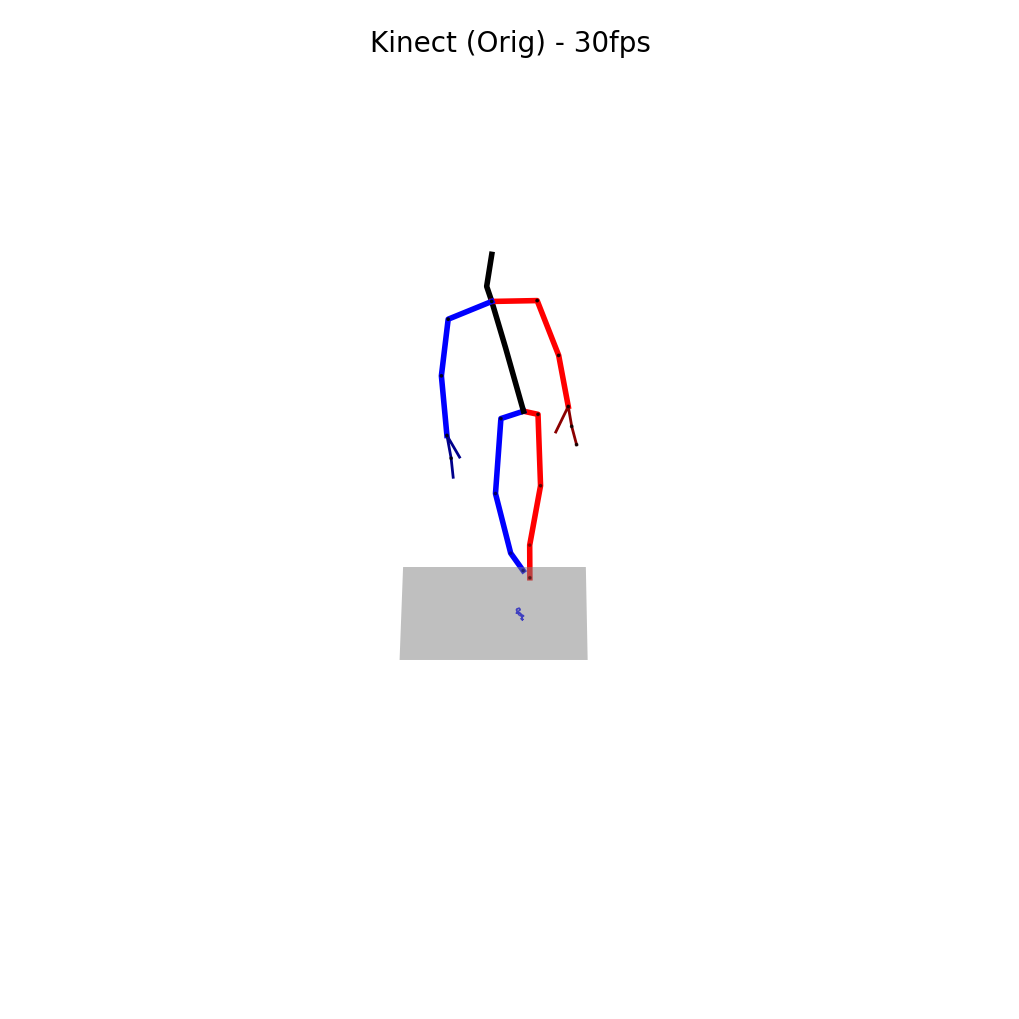

In [7]:
USE_ROTATION = False
OVERWRITE = True # whether to overwrite existing files

orig_filepath = pjoin(PROJECT_DIR, 'data', DATASET, DATA_FILENAME[DATASET])
print(f"Loading {DATASET} original annotations from {orig_filepath} ...")
with open(orig_filepath, 'rb') as file:
    orig_annotations = pickle.load(file)['annotations']

with open(pjoin(TASK_DIR, SPLIT + '.txt'), 'r') as file:
    npy_files = [line.rstrip('\n') + '.npy' for line in file]

npy_files = sorted(npy_files)[:NUM_ANIMATIONS]
print(f"Processing animations: {npy_files}")
for npy_file in tqdm(npy_files):
    joints_forw = np.load(pjoin(SRC_DIR, npy_file))
    name = npy_file.split('.')[0]

    joints_forw, contacts = redundant_to_xyz(joints_forw, use_rotation=USE_ROTATION)
    joints_back = backward_map(joints_forw)
    joints_orig = next( # NOTE: only first skeleton is plotted
        (data['keypoint'][0] for data in orig_annotations if data['frame_dir'] == name),
        None
    )
    assert joints_orig is not None, f"Original joints for {name} not found in annotations."

    joints_orig = viz_skel_transform(joints_orig, skel_name='KINECT')
    
    forw_save_path = pjoin(TGT_ANI_DIR, DATASET, name, 'forw.mp4')
    backw_save_path = pjoin(TGT_ANI_DIR, DATASET, name, 'back.mp4')
    orig_save_path = pjoin(TGT_ANI_DIR, DATASET, name, 'orig.mp4')
    os.makedirs(os.path.dirname(forw_save_path), exist_ok=True)
    os.makedirs(os.path.dirname(backw_save_path), exist_ok=True)
    os.makedirs(os.path.dirname(orig_save_path), exist_ok=True)

    if not OVERWRITE and (os.path.exists(forw_save_path) or os.path.exists(backw_save_path) or os.path.exists(orig_save_path)):
        continue

    radius = 2.0 if not USE_ROTATION else 12.0
    # You may set the title on your own.
    plot_3d_motion(forw_save_path, forw_kinematic_chain, joints_forw, title="SMPL (Forw) - 20fps", fps=20, radius=radius, foot_contacts=contacts)
    plot_3d_motion(backw_save_path, back_kinematic_chain, joints_back, title="Kinect-reduced (Backw) - 20fps", fps=20, radius=radius, foot_contacts=None)
    plot_3d_motion(orig_save_path, orig_kinematic_chain, joints_orig, title="Kinect (Orig) - 30fps", fps=30, radius=radius, foot_contacts=None)

print(f"Saved animations to {TGT_ANI_DIR}/{DATASET}/<name>/*.mp4")

<br><br>

---
---
---